# MSM of the alanine dipeptide
In this example we use different methods for estimating the transition and rate matrices for a simple two-state MSM of the alanine dipeptide. Again, first one must download files from the following [link](https://drive.google.com/drive/folders/1hkx7G1qPutEX-4s-AHHtdvpHqsTwgSNn?usp=sharing).

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%pylab inline
import math
import numpy as np
import copy
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})

Populating the interactive namespace from numpy and matplotlib


In [2]:
import mdtraj as md
from mastermsm.trajectory import traj

First we read the trajectory data, here corresponding to the Gromacs `xtc` files using the [`MDtraj`](http://mdtraj.org) library.

In [3]:
tr = traj.TimeSeries(top='data/alaTB.gro', traj=['data/protein_only.xtc'])

Then we discretize the data using Ramachandran states. Only alpha (`A`), extended (`E`) and left-handed (`L`) configurations are accepted.

In [4]:
tr.discretize(states=['A', 'E', 'L'])
tr.find_keys()

In order to enforce detailed balance we revert the assigned time series and use both trajectories to build the Markov model.

In [5]:
tr_rev = copy.deepcopy(tr)
tr_rev.distraj = [x for x in reversed(tr.distraj)]

Using the discretized data we build the MSM invoking the `SuperMSM` class.

In [6]:
from mastermsm.msm import msm
msm_alaTB = msm.SuperMSM([tr, tr_rev], sym=False)


 Building MSM from 
 [['data/protein_only.xtc'], ['data/protein_only.xtc']]
     # states: 3


We then calculate the transition matrix for a set of lag times.

In [7]:
lagts = [1, 2, 5, 7, 10, 20, 50, 100]
for lt in lagts:
    msm_alaTB.do_msm(lt)
    msm_alaTB.msms[lt].do_trans()
    #msm_alaTB.msms[i].boots(plot=False)

The rate matrix can be calculated using a simple Taylor expansion. The  method produces acceptable solutions for short lag times although the result rapidly diverges from the transition matrix relaxation time at long lag times. The rate matrix elements have the following values:

In [8]:
msm_alaTB.msms[1].do_rate()
print (msm_alaTB.msms[1].rate)
rate_Taylor = msm_alaTB.msms[1].rate
tau_Taylor = msm_alaTB.msms[1].tauK
peq_Taylor = msm_alaTB.msms[1].peqK

[[-1.18318012e-02  1.70391406e-02  6.41025641e-03]
 [ 1.17466803e-02 -1.71626127e-02  6.41025641e-03]
 [ 8.51208716e-05  1.23472034e-04 -1.28205128e-02]]


Alternatively, we can use the lifetime based method, where we use branching probabilities and average lifetimes. The rate is almost identical to that from the Taylor expansion.

In [9]:
msm_alaTB.do_lbrate()
print (msm_alaTB.lbrate)

[[-1.18691828e-02  1.70623145e-02  6.41025641e-03]
 [ 1.17837930e-02 -1.71859545e-02  6.41025641e-03]
 [ 8.53898045e-05  1.23639960e-04 -1.28205128e-02]]


Clearly, both methods yield approximately the same result. Finally, we use Buchete and Hummer's maximum likelihood propagator-based method, which is also implemented in MasterMSM.

MLPB optimization of rate matrix:
 START

 END of cycle 1
   acceptance :0.505111
[[-1.20644433e-02  1.90446649e-02  8.81535020e-03]
 [ 1.19790535e-02 -1.93001743e-02  1.65916552e-02]
 [ 8.53898045e-05  2.55509466e-04 -2.54070054e-02]]
   L old = 1481.7173783567985 ; L new: 1483.364623513922
   improvement :-0.00111171

 END of cycle 2
   acceptance :0.414222
[[-1.19450841e-02  1.73390507e-02  7.17041237e-03]
 [ 1.18596943e-02 -1.74581963e-02  6.84328028e-03]
 [ 8.53898045e-05  1.19145608e-04 -1.40136926e-02]]
   L old = 1483.6097973610413 ; L new: 1481.7104165536052
   improvement :0.00128024

 END of cycle 3
   acceptance :0.401
[[-1.19724390e-02  1.73177954e-02  6.45327370e-03]
 [ 1.18870492e-02 -1.74515321e-02  6.93755217e-03]
 [ 8.53898045e-05  1.33736742e-04 -1.33908259e-02]]
   L old = 1483.1363638195853 ; L new: 1481.7051037213157
   improvement :0.000965023
[[-1.19724390e-02  1.72903801e-02  6.17625926e-03]
 [ 1.18870492e-02 -1.74241169e-02  6.65027736e-03]
 [ 8.53898045e-05  

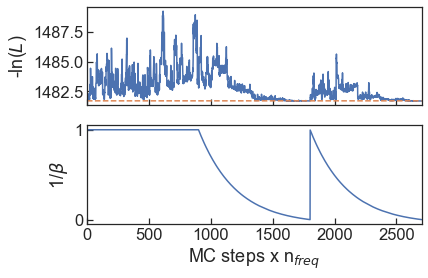

In [10]:
msm_alaTB.msms[1].do_rate(method='MLPB', init=msm_alaTB.lbrate, \
                          report=True)
print (msm_alaTB.msms[1].rate)

Finally we compare the eigenvalues and equilibrium probabilities from the three methods and those from the transition probability matrix.

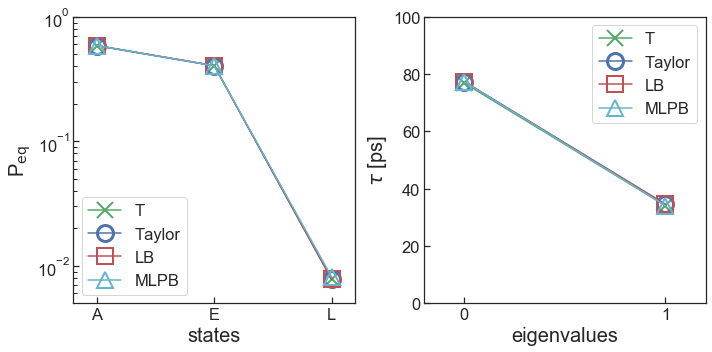

In [11]:
fig, ax = subplots(1,2, figsize=(10,5))
ax[0].plot(msm_alaTB.msms[1].peqT, 'x-', markersize=16, \
           markeredgewidth=2, color='g', markeredgecolor='g', \
           markerfacecolor='None', label='T')
ax[0].plot(peq_Taylor, 'o-', markersize=16, markeredgewidth=3, \
           color='b', markeredgecolor='b', markerfacecolor='None',\
           label='Taylor')
ax[0].plot(msm_alaTB.peqK, 's-', markersize=16,markeredgewidth=2, \
           color='r', markeredgecolor='r', markerfacecolor='None', \
           label='LB')
ax[0].plot(msm_alaTB.msms[1].peqK, '^-', markersize=16, \
           markeredgewidth=2, color='c', markeredgecolor='c', \
           markerfacecolor='None', label='MLPB')
ax[0].set_xlim(-0.2,2.2)
ax[0].set_xlabel('states', fontsize=20)
ax[0].set_ylim(5e-3,1)
ax[0].set_xticks([0,1,2])
ax[0].set_xticklabels(["A","E", "L"])
ax[0].set_ylabel('P$_\mathrm{eq}$', fontsize=20)
ax[0].set_yscale('log')

ax[1].plot(msm_alaTB.msms[1].tauT, 'x-', markersize=16, \
           markeredgewidth=2, color='g', markeredgecolor='g', \
           markerfacecolor='None', label='T')
ax[1].plot(tau_Taylor, 'o-', markersize=16, markeredgewidth=3, \
           color='b', markeredgecolor='b', markerfacecolor='None', \
           label='Taylor')
ax[1].plot(msm_alaTB.tauK, 's-', markersize=16,markeredgewidth=2, \
           color='r', markeredgecolor='r', markerfacecolor='None', \
           label='LB')
ax[1].plot(msm_alaTB.msms[1].tauK, '^-', markersize=16, \
           markeredgewidth=2, color='c', markeredgecolor='c', \
           markerfacecolor='None', label='MLPB')
ax[1].set_ylabel(r'$\tau$ [ps]', fontsize=20)
ax[1].set_xlabel('eigenvalues', fontsize=20)
ax[1].set_xlim(-0.2,1.2) 
ax[1].set_ylim(0,100) 
ax[1].set_xticks([0,1])
ax[0].legend(loc=3)
ax[1].legend(loc=1)
plt.tight_layout()